# Feature transformation

The first part of this introduction to dimensionality reduction focuses on feature **transformation**. We will apply linear and nonlinear approaches used in machine learning to represent high-dimensional data in a lower-dimensional space.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import MDS, TSNE
import umap
from sklearn.metrics.pairwise import pairwise_distances

## Dataset

We will use a gene expression dataset of tomato plants. For each plant sample, we have expression measurements for more than 28k genes. They tell us something about the biological processes going on in the plant when the sample was taken. The dataset was downloaded from GEO, one of the major public repositories for gene expression data ([link](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE45774&format=file&file=GSE45774_rpkm_all.txt.gz)), and is associated with a [PNAS publication](https://www.pnas.org/doi/full/10.1073/pnas.1309606110).

There are 24 samples, which cover all combinations of three experimental factors:
- Plant tissue: floral tissue, leaf, root, seedling, stem, vegetative tissue
- Tomato species: Solanum lycopersicum M82 (domesticated), Solanum pennellii (wild, desert-adapted)
- Growing position: sun, shade

For convenience, we provide a reformatted version of the data.

In [5]:
data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
data_with_labels.head()

,Solyc02g081130.1.1,Solyc12g038200.1.1,Solyc00g097760.1.1,Solyc08g069180.2.1,Solyc01g012570.1.1,Solyc08g076670.2.1,Solyc04g024840.2.1,Solyc09g074310.2.1,Solyc09g005370.1.1,Solyc12g098180.1.1,...,Solyc01g088670.1.1,Solyc06g063380.1.1,Solyc10g050450.1.1,Solyc07g051990.1.1,Solyc02g093490.2.1,Solyc10g007270.2.1,species,position,tissue,root
penn.Sh.floral,1.169216,0.000000,0.0,1.305753,0.0,4.634343,2.860965,3.242561,0.0,0.0,...,2.120579,0.0,0.000000,0.0,5.027894,0.0,penn,Sh,floral,0
penn.Sh.leaf,0.000000,0.858644,0.0,2.948383,0.0,4.653912,2.241161,2.922573,0.0,0.0,...,1.370140,0.0,2.006256,0.0,5.068390,0.0,penn,Sh,leaf,0
penn.Sh.root,0.000000,0.000000,0.0,0.469958,0.0,5.798938,3.217704,2.229663,0.0,0.0,...,1.970763,0.0,1.688588,0.0,4.889667,0.0,penn,Sh,root,1
penn.Sh.sdling,1.813992,0.000000,0.0,2.586147,0.0,4.771861,3.099842,3.452604,0.0,0.0,...,1.982446,0.0,1.651062,0.0,3.105620,0.0,penn,Sh,sdling,0
penn.Sh.stem,0.000000,0.000000,0.0,1.540887,0.0,4.907770,4.800873,1.973890,0.0,0.0,...,1.452937,0.0,0.000000,0.0,4.993720,0.0,penn,Sh,stem,0


## Principal component analysis (PCA)

How can we check which samples are (dis)similar to each other? Does the species or the growing position have a greater influence on the gene expression? Clearly, it is not an option to visualize all 28k gene expression levels of each sample. Principal component analysis (PCA) is a suitable first approach to reduce the dimensionality and visualize your dataset.

In [6]:
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1)
scaler = StandardScaler().set_output(transform="default")
data = scaler.fit_transform(data_original)
pc = PCA(n_components=10)
data_transformed = pc.fit_transform(data)

First, we visualize the data based on the first two principal components. This will show us the main sources of variation. Since we do not have any prior knowledge which experimental factors have the greatest influence on the gene expression, we use all the label information that is available to us to mark the samples (here, the color indicates the tissue, and the shape indicates the combination of species and growing condition). What is the main source of variation in this data set? Side remark: If we have more label combinations than can be distinguished in one plot, we can produce multiple plots, e.g. one for each labeling type (tissue, species, condition).

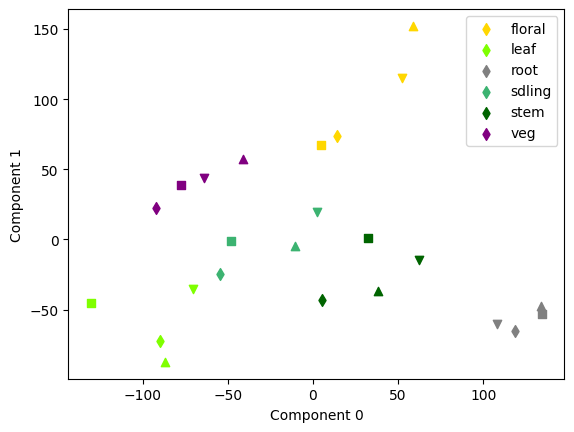

In [7]:
tissue_dict = {'floral': 'gold', 'leaf': 'chartreuse', 'root': 'gray', 'sdling': 'mediumseagreen', 'stem': 'darkgreen', 'veg': 'purple'}
species_condition_dict = {'penn.Sun': 's', 'penn.Sh': 'd', 'M82.Sun': '^', 'M82.Sh': 'v'}
def plot_components(data_transformed, j=0, k=1, tissuelegend=True):
    for i in range(0,data_transformed.shape[0]):
        plt.scatter(data_transformed[i,j], data_transformed[i,k], marker=species_condition_dict['.'.join([data_with_labels.iloc[i]['species'], data_with_labels.iloc[i]['position']])], c=tissue_dict[data_with_labels.iloc[i]['tissue']])
    plt.xlabel("Component {}".format(j)) 
    plt.ylabel("Component {}".format(k))
    if tissuelegend:
        plt.legend(tissue_dict, loc="upper right")
    else:
        def make_markers(ind):
            return(plt.Line2D([], [], color='black', marker=list(species_condition_dict.values())[ind], linestyle='None'))
        plt.legend([make_markers(l) for l in range(0,len(species_condition_dict.values()))], species_condition_dict.keys(), loc="upper right")
    plt.show()
plot_components(data_transformed)

The plot reveals that the tissue type is the main source of variation in the data. Samples of the same tissue type are clustered together. Next, we will also have a look at the third principal component (at index 2) and check its combinations with the first two components.

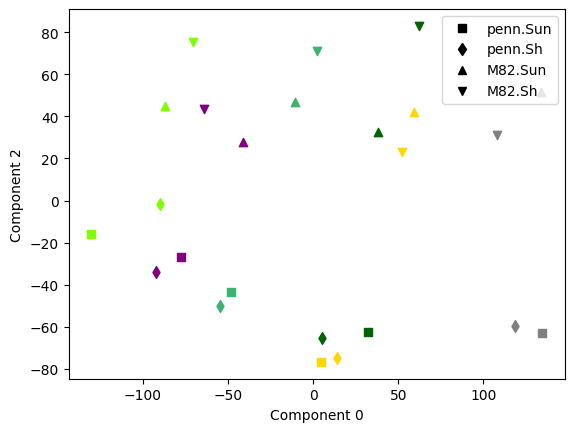

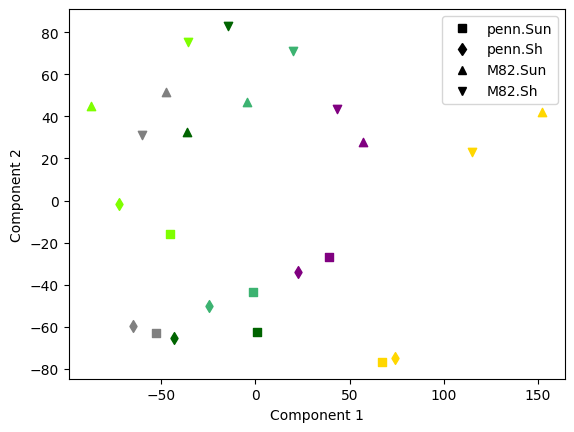

In [42]:
xval = [0,1]
yval = [2,2]
for k in range(0,len(xval)):
    plot_components(data_transformed, xval[k], yval[k], False)

Clearly, the third principal component separates the squares and diamonds from the triangles, i.e. it separates the two species. By changing xval and yval, you can visualize combinations with even higher principal components. However, they do not contain a separation of growing conditions, so this factor does not play a big role for the gene expression variation in this data set. How should we decide on the number of principal components to include in further analyses? Here we knew from our labels that it might be worthwile to go beyond tissue effects, but in general scientists typically interrogate the cumulative explained variance to see how many components are needed to retain a certain percentage of variance (e.g. 75%).

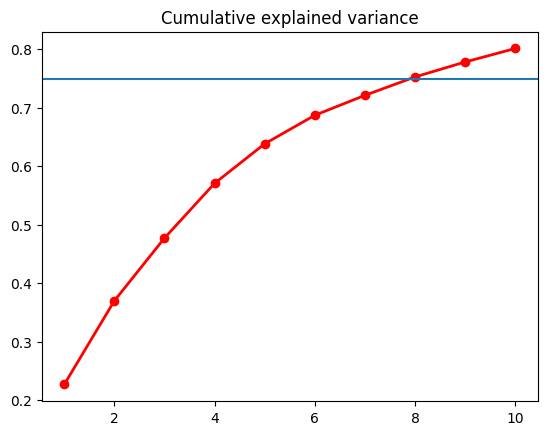

In [6]:
pc.explained_variance_ratio_
pc.explained_variance_ratio_.cumsum()
PC_values = np.arange(pc.n_components_) + 1
plt.plot(PC_values, pc.explained_variance_ratio_.cumsum(), 'ro-', linewidth=2)
plt.axhline(0.75)
plt.title('Cumulative explained variance')
plt.show()

Thus, we decide for instance to go with the top 8 principal components, so we have 8-dimensional representations of our samples instead of 28k-dimensional representations. Note that each principal component is a linear combination of all gene expression values. For example, we saw before that the third principal component separates the two species. Here we show a histogram presentation of the third principal component values across all samples, colored by species.

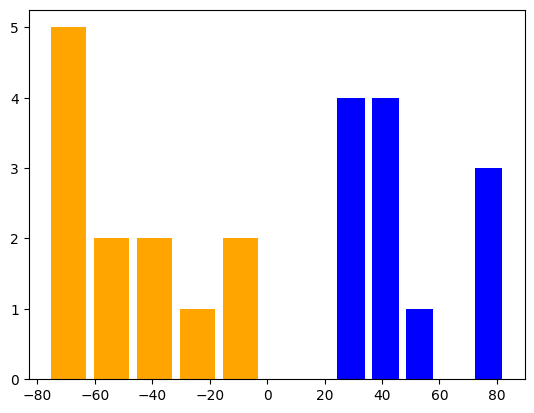

In [7]:
w = np.where(data_with_labels['species']=='M82')
plt.hist(data_transformed[w,2], bins=5, density=False, histtype='barstacked', rwidth=0.8, facecolor='blue')
plt.hist(np.delete(data_transformed[:,2], w), bins=5, density=False, histtype='barstacked', rwidth=0.8, facecolor='orange')
plt.show()

Going back to gene space, the top-weight gene of the third principal component also shows distinct expression levels in the two species.

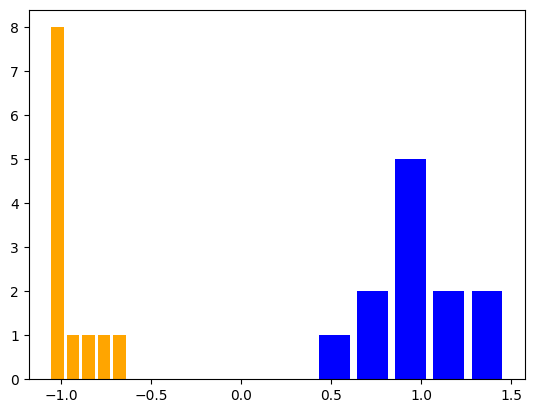

In [8]:
wmax = np.argmax(pc.components_[2,:])
plt.hist(data[w,wmax], bins=5, density=False, histtype='barstacked', rwidth=0.8, facecolor='blue')
plt.hist(np.delete(data[:,wmax], w), bins=5, density=False, histtype='barstacked', rwidth=0.8, facecolor='orange')
plt.show()

In general, it is not necessarily the case that single features show the same behavior as the principal component, which has contributions from all the features. Later in this course we will also see approaches that directly select features with desired properties. For now, we continue with further feature transformation methods, which are suitable for a first, unsupervised analysis of a dataset (including quality control).

## Independent component analysis (ICA)

A popular alternative to principal component analysis is independent component analysis. Let's try it on the same dataset.

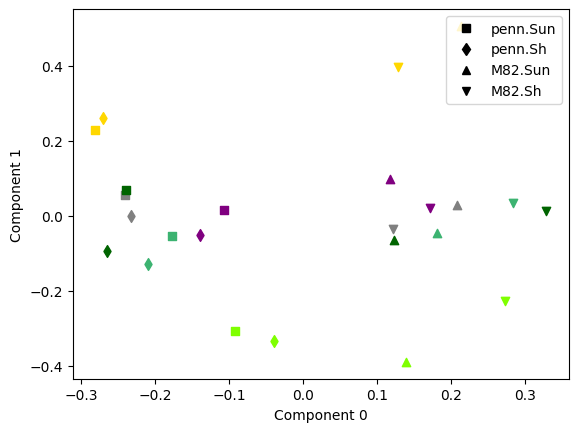

In [45]:
ica = FastICA(n_components=3, whiten="arbitrary-variance", random_state=33)
data_transformed = ica.fit_transform(data)
plot_components(data_transformed, tissuelegend=False)

Here, the first component separates the two species. Please note that in contrast to principal component analysis, the order of components is arbitrary. If you change the random_state parameter, the result might be different. Let's plot the further pairs of components for the current random_state.

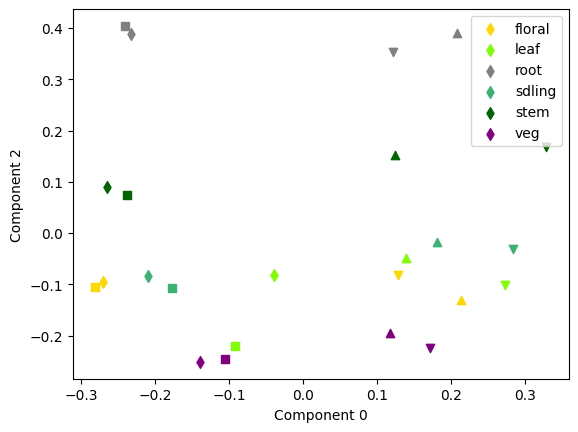

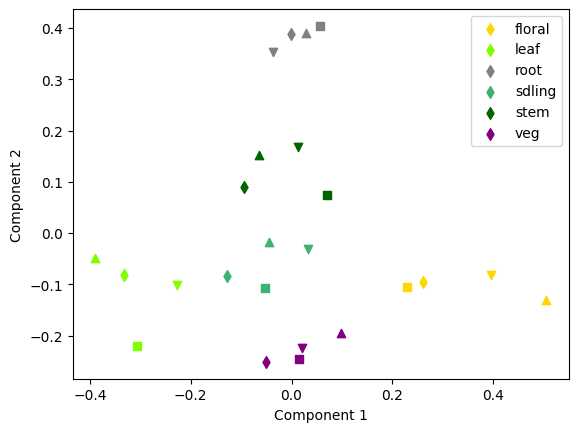

In [46]:
xval = [0,1]
yval = [2,2]
for k in range(0,len(xval)):
    plot_components(data_transformed, xval[k], yval[k], True)

The last plot (second and third component) show a separation of tissues similar to the first two principal components.

## Multidimensional scaling (MDS)

The idea of multidimensional scaling is to preserve the pairwise distances of samples from the original space as much as possible when showing them in a low-dimensional display (usually two-dimensional). Using Euclidean distances and metric MDS will yield us linear transformations related to PCA, but other variants allow constructing non-linear projections from the high-dimensional expression space to a two-dimensional display.

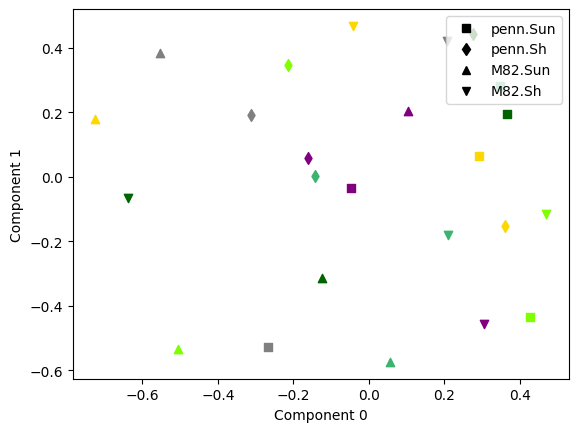

0.27124420325950493

In [24]:
mds = MDS(n_components=2, metric=False, normalized_stress=True, random_state=33)
data_transformed = mds.fit_transform(data)
plot_components(data_transformed, tissuelegend=False)
mds.stress_

This method seems to fail here completely, since we do not get any convincing patterns with respect to the known experimental factors (tissue, species etc.). A stress score of 0 would be optimal and a value of up to 0.1 would be acceptable according to the documentation of the MDS class.

### Task
1. Use the cell below to try the analysis with other random seeds. What do you observe?
2. What else could we change to alter the results of this method? 

In [9]:
# Insert code for task

Overall, the method aims to preserve the rank order of pairwise distances in the display. Let us check how well it succeeded.

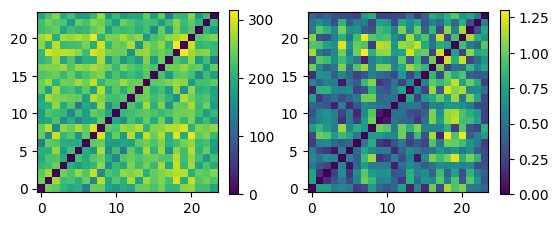

In [25]:
plt.subplot(1,2,1)
plt.imshow(mds.dissimilarity_matrix_, origin='lower', interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.subplot(1,2,2)
plt.imshow(pairwise_distances(data_transformed), origin='lower', interpolation='nearest')
plt.colorbar(shrink=0.5)

Some aspects of the overall structure were preserved from the original distance matrix (left) to the distance matrix in the display (right). For example, both times samples 8 and 18-20 have large distances to all other samples, whereas samples 3-6 are relatively close to each other. However, the strongest local similarity structures differ between the original and the transformed space. 

Consequently, the local neighborhoods in the display are not necessarily trustworthy. Similar to the precision and recall measures in information retrieval and classification, we can assess our visualization with respect to competing goals: 
- Are samples that are close to each other in the visualization also similar in the original space?
- How many of the original neighbors are neighbors in the visualization?

We use a  contingency table to compare the local neighborhoods between the original and the low-dimensional space. 

In [28]:
def compute_neighbor_confusion(dist1, dist2, k=4):
    np.fill_diagonal(dist1, np.inf)
    np.fill_diagonal(dist2, np.inf)
    confusion_matrix = np.zeros((2, 2))
    
    for i in range(dist1.shape[0]):
        s1 = np.argsort(dist1[i,])
        w1 = s1[:k]
        s2 = np.argsort(dist2[i,])
        w2 = s2[:k]
        b = len(np.setdiff1d(w1, w2))
        c = len(np.setdiff1d(w2, w1))
        d = len(np.intersect1d(w1, w2))
        a = dist1.shape[1] - 1 - b - c - d # instance itself does not count as neighbor or non-neighbor, therefore -1
        currmatrix = np.array([[a, c], [b, d]])
        confusion_matrix += currmatrix
    
    return confusion_matrix
array = compute_neighbor_confusion(mds.dissimilarity_matrix_, pairwise_distances(data_transformed))
df = pd.DataFrame(data = array,  
                  index = ['No neighbor (original space)', 'Neighbor (original space)'],  
                  columns = ['No neighbor (display)', 'Neighbor (display)']) 
print(df)

                              No neighbor (display)  Neighbor (display)
No neighbor (original space)                  383.0                73.0
Neighbor (original space)                      73.0                23.0


For each instance, the four closest instances are considered as neighbors. On average, only about one out of four neighbors (23 out of 96) are kept in the display, indicating that the local neighborhoods are not well preserved.

## t-Distributed stochastic neighbor embedding (t-SNE)

The nonlinear transformation method t-SNE addresses the problem described above, aiming to preserve local structure at multiple scales.

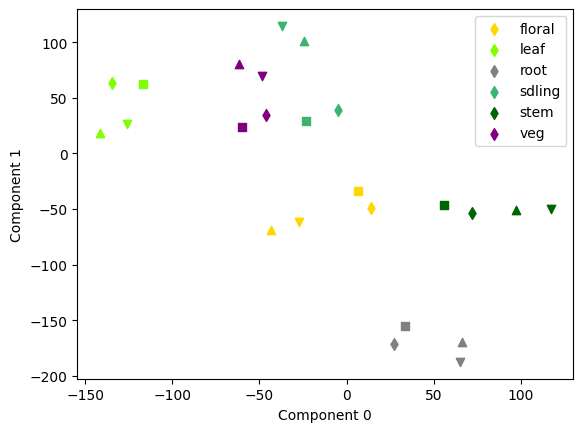

In [48]:
tsne = TSNE(n_components=2, perplexity=5, init="pca", random_state=33)
data_transformed = tsne.fit_transform(data)
plot_components(data_transformed)

We see a clear separation of species subclusters within each tissue.

## Uniform manifold approximation and projection (UMAP)

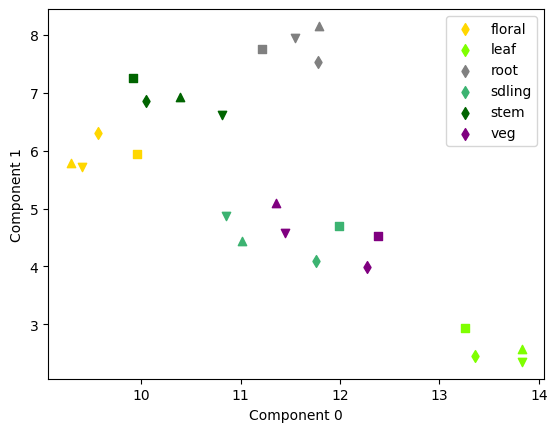

In [73]:
reducer = umap.UMAP(n_neighbors=5, random_state=33, n_jobs=1) # if we use seed, no parallel jobs can be used
data_transformed = reducer.fit_transform(data)
plot_components(data_transformed)

Similar to t-SNE, species subgroups from each tissue are often clustered. However, some tissues are now overlapping. UMAP constructs a k-neighbor graph and computes a low-dimensional layout of this graph. It also works for very huge datasets because it is much more efficient than t-SNE.

### Task
1. Given a specific dataset, what would be a reason for preferring nonlinear transformation methods to linear transformation methods?
2. What are potential drawbacks of nonlinear methods?

## Canonical correlation analysis (CCA)

CCA is a multimodal dimension reduction method. It can be used to co-analyze data from different omics types or feature sets regarding their strongest correlations. As a linear feature transformation method it is a generalization of PCA.

In [ ]:
# translate from R
# Example: correlating photosynthesis and cell growth genes from Gene Ontology (GO) on tomato dataset